#### Keras 를 활용한 간단한 ML 기초입니다.


기본적으로 Machine Learning 은 최종 Target 을 맞추기 위해 
적당히 선형으로 결합된 network graph를 먼저 설계하고 그 graph의 weight 에 해당하는 값을
데이터에 맞추어 자동으로 튜닝하는 내용으로 이루어져 있습니다.

보통 이 tune 을 해주는 프로그램으로 유명한게 tensorflow / pytorch 등이 있으며
이번에 소개해드릴 keras는 tensorflow (또는 theano) 를 backend 로 하여 돌아가는 일종의 wrapper 입니다.

아래는 임의의 X1~X5 의 변수를 이용해서 설계된 Y 를 맞추는 회귀 예제입니다.


-- by m.song   7/10


In [1]:
# 필수 라이브러리 로드 
# Tensorflow에 keras가 포함되었기 때문에 별도 keras 설치는 안해도 됨
import tensorflow as tf
import pandas as pd
import numpy as np


데이터 로드하기, 데이터는 엑셀에서 임의로 생성하였으며 (Toy MC) example1 부터 5 까지 점점 복잡한 조합으로 (선형, 제곱/나누기등 비선형, 초월함수 사용등) 구성되어 있습니다.

In [2]:
#df_train = pd.read_csv("example1_train.csv", sep="\t")
#df_test = pd.read_csv("example1_test.csv", sep="\t")
df = pd.read_csv("example5.csv", sep="\t")

사실 아래처럼 데이터를 나누는 것은 좋은 방법은 아닙니다. 데이터들의 index 에는 다른 정보 (ex 시간으로 sorting 되어 있다던지) 가 포함되어 있는 경우가 많기 때문에
Train / Test 데이터를 제대로 나누기 위해서는 shuffle 등의 방법을 사용하는게 좋습니다. 여기서는 그냥 편의를 위해 index를 기준으로 나누었습니다.

In [3]:
train_x = np.array(df.iloc[:4000][['x1','x2','x3','x4', 'x5']])
train_y = np.array(df.iloc[:4000][['y']])
test_x = np.array(df.iloc[4001:][['x1','x2','x3','x4','x5']])
test_y = np.array(df.iloc[4001:][['y']])

주어진 데이터를 넣을 모델(network graph)를 만듭니다. 보시는 바와 같이 input shape을 지정해주지 않아도 알아서 적당히 만드는데는 문제가 없습니다.
다만 이렇게 모델을 구성하면 `model.summary()` 등을 통해 확인할 수 가 없습니다. (실제 데이터가 들어오기전까지는 input layer가 어떻게 생겼는지 모르기 때문에)

In [4]:
model = tf.keras.Sequential()

model.add( tf.keras.layers.Dense( 20, activation='relu') )
model.add( tf.keras.layers.Dense( 20, activation='relu') )
model.add( tf.keras.layers.Dense( 1) )

보다 제대로 된 정석적인 방법은 다음처럼 모델의 첫번째 layer로 Input layer를 명시해주는 것입니다.

In [5]:
model2 = tf.keras.Sequential()

model2.add( tf.keras.layers.InputLayer( input_shape = train_x[0].shape ))
model2.add( tf.keras.layers.Dense( 20, activation = "relu"))
model2.add( tf.keras.layers.Dense( 20, activation = "relu"))
model2.add( tf.keras.layers.Dense( 1 ) )

위와같이 `model2.add( tf.keras.layers.InputLayer( input_shape = train_x[0].shape ))` 가 추가 되면 이후 아래처럼 summary 를 통해 network를 미리 확인 가능합니다. 또는 보다 화려하게
`tf.keras.utils.plot_model(model2)` 등을 통해서도 확인이 가능합니다. 다만 화려함에 비해서 별로 얻을 수 있는 정보는 없습니다. ;-)

In [6]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 20)                120       
                                                                 
 dense_4 (Dense)             (None, 20)                420       
                                                                 
 dense_5 (Dense)             (None, 1)                 21        
                                                                 
Total params: 561 (2.19 KB)
Trainable params: 561 (2.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
tf.keras.utils.plot_model(model2, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


이제 학습(데이터를 넣고 맞춰볼)을 진행할 때, 사용할 방법론을 지정해줘야 합니다. 가장 쉬운 예제는 경사하강법 (Gradient Decent - 줄여서 GD) 이지만, 성능이 좋지 않아서 최근에는 adaboost, adam 등이 사용됩니다.
여기서는 일단 adam 을 써보기로 합니다. (옵티마이저는 나중에 설명드리겠습니다.)

또한 우리가 맞추는 문제는 numeric한 숫자를 맞추는 것이므로, 얼마나 근사하게 맞췄느냐를 metric 으로 가지는 loss (손실)함수를 사용하겠습니다.
MSE 는 (mean square error) 로  차이의 제곱 평균을 한 값을 사용합니다.

예를들어
-  실제 4 인데 예측 5 이면 -- 1 만큼 틀림 (손실값 1)
-         실제 4 인데 예측 10이면 -- 36 만큼 틀림 (손실값 36)
         
제곱이 붙었으므로 많이 틀릴 수록 손실이 커지므로 최대한 실제 정답과 비슷한 값이 되어야 손실함수가 minimize 되고, 학습은 손실함수가 최소가 되게 학습하므로
점점 모델을 실제값과 예측값이 비슷해지게 될 것입니다.

In [8]:
model.compile(optimizer='adam',  loss='mse'    )

이제 실제 학습을 진행합니다. 데이터를 반복해서 학습하며, 그 학습 횟수는 epochs 로 나타내고 에포크가 20번 정도 되도록 학습을 하겠습니다. 이렇게 외부에서 주는
값들을 하이퍼파라메터라고 부르며, 이를 얼마나 최적화 하는가는 순전히 사용자의 경험과 실력에 좌지우지 됩니다.

In [9]:
model.fit(x=train_x, y=train_y, epochs=10)

Epoch 1/10
125/125 [==============================] - 0s 531us/step - loss: 0.5858
Epoch 2/10
125/125 [==============================] - 0s 484us/step - loss: 0.0664
Epoch 3/10
125/125 [==============================] - 0s 487us/step - loss: 0.0335
Epoch 4/10
125/125 [==============================] - 0s 477us/step - loss: 0.0143
Epoch 5/10
125/125 [==============================] - 0s 492us/step - loss: 0.0089
Epoch 6/10
125/125 [==============================] - 0s 480us/step - loss: 0.0069
Epoch 7/10
125/125 [==============================] - 0s 479us/step - loss: 0.0053
Epoch 8/10
125/125 [==============================] - 0s 485us/step - loss: 0.0042
Epoch 9/10
125/125 [==============================] - 0s 460us/step - loss: 0.0034
Epoch 10/10
125/125 [==============================] - 0s 465us/step - loss: 0.0028


-----
loss 값을 가지고 학습이 제대로 되었는 지 대충 가늠해 볼 수 있습니다. 위에서 언급한 바와 같이 Loss는 작을수록 학습이 잘 된겁니다. 
(다만 과적합에 대해서는 차후 이야기하겠습니다.)

이제 처음에 나누었던 test set에 대해서도 검증을 해보겠습니다.

In [10]:
model.evaluate(x=test_x, y=test_y)

18/18 [==============================] - 0s 507us/step - loss: 0.0026


0.0026088496670126915

model 의 evaluate 맴버 펑션을 사용하면, 같은 weight를 가지는 (학습이 완료된) network 를 사용해서 x / y 값을 평가해 볼 수 있습니다.
마찬가지로 Loss 가 굉장히 작음을 확인할 수 있습니다.

실제 값과, 예측 값을 각각  x , y 축으로 표현해서 산점도 그래프로 나타내보면, 둘이 잘 일치함을 확인할 수 있습니다.

18/18 [==============================] - 0s 480us/step


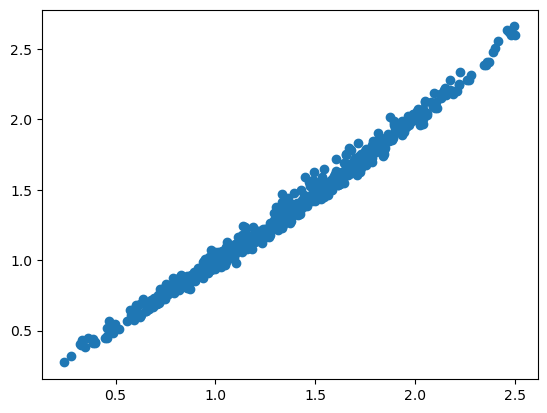

In [11]:
import matplotlib.pyplot as plt
plt.scatter( model.predict(test_x), test_y )